The program is to find the longest possible path in a graph crossing each node exactly once. By the by, it also checks if the graph is Hamiltonian or not.
"Graph G has a Hamiltonian path if and only if its longest path has length n − 1, where n is the number of vertices in G" -> https://en.wikipedia.org/wiki/Longest_path_problem

In [501]:
import networkx as nx
import random
import pygad
import matplotlib.pyplot as plt
import time
import math

In [502]:
def generate_digraph(num_nodes):
    G = nx.DiGraph()
    # Add nodes to the graph
    for i in range(num_nodes):
        G.add_node(i)
    # Add edges to the graph
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            if random.random() < 0.5:
                weight = random.randint(1, 5)
                G.add_edge(i, j, weight=weight)
    return G

In [503]:
def draw_digraph(graph):
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos=pos, with_labels=True)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

In [504]:
def normalize_solution(graph, solution):
    current_node = solution[0] % graph.number_of_nodes()
    normalized_solution = [current_node]
    
    for direction in solution[1:]: # Skip the first node as it is our starting point
        if direction % 2 == 1:
            break
        out_edges = list(graph.out_edges(current_node))
        if len(out_edges) == 0:
            break
        normalized_direction = (direction // 2) % len(out_edges)
        normalized_solution.append(normalized_direction)
        current_node = out_edges[normalized_direction][1]
    return normalized_solution

In [505]:
def convert_solution_to_path(graph, solution):
	normalized_solution = normalize_solution(graph, solution)
	current_node = normalized_solution[0]
	path = [current_node]
	for norm_direction in normalized_solution[1:]:
		out_edges = list(graph.out_edges(current_node))
		current_node = out_edges[norm_direction][1]
		path.append(current_node)
	return path

In [506]:
def generate_fitness_function(graph):
    def fitness_function(solution, solution_idx):
        normalized_solution = normalize_solution(graph, solution)
        current_node = normalized_solution[0]
        current_path_length = 0
        for normalized_direction in normalized_solution[1:]:
            out_edges = list(graph.out_edges(current_node, data=True))
            current_node = out_edges[normalized_direction][1]
            current_path_length += out_edges[normalized_direction][2]['weight']

        path = convert_solution_to_path(graph, solution)
        countByNode = {}
        for node in path:
            if node not in countByNode:
                countByNode[node] = 0
            countByNode[node] += 1
        # decrease every node count by 1 so that we don't punish the node for being visited once
        for node in countByNode:
            countByNode[node] -= 1
        fitness = current_path_length
        for node in countByNode:
            fitness -= 10 * math.pow(countByNode[node], 2)


        return fitness
    return fitness_function                                            

Firstly, fitness function goes through every gene of given chromosome (solution) and checks if a gene is "connected" to the next gene in array (edges). If so, the function adds the weight of an edge to the path length. Then function rewards diversity of each solution, meaning non-repeating genes in every chromosome. That's because we want the path to be simple - it has to go through every node exactly once. If every node in graph is connected then this condition serves a purpose of breaking the loop that normally would meet a "index out of range" error when trying to get (i + 1)-th node. Also, the diversity award is multiplied by 5 to ensure that there are no duplicates in our solution.

In [507]:
# Define the initial population
def create_population(pop_size, nodes_count):
    return [[random.randint(0, 100) for _ in range(nodes_count)] for _ in range(pop_size)]

In [508]:
#Declare the number of nodes in the graph

number_of_nodes = 10

In [509]:
graph = generate_digraph(number_of_nodes)
# draw_digraph(graph)

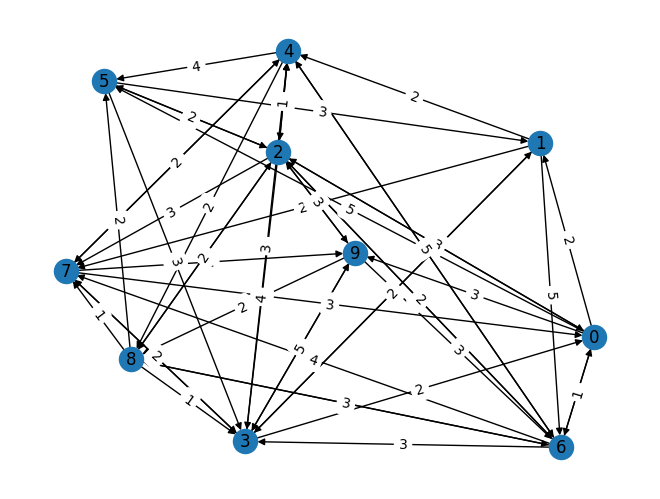

Run  1
Best solution: [9, 3, 2, 1, 4, 4, 0, 0, 0, 2]
Best solution (path): [9, 8, 5, 2, 6, 7, 0, 1, 3, 4]
Fitness: 27.0
-------------------------------------------
Run  2
Best solution: [9, 0, 2, 1, 0, 2, 5, 4, 1, 0]
Best solution (path): [9, 2, 4, 5, 1, 6, 8, 7, 3, 0]
Fitness: 29.0
-------------------------------------------
Run  3
Best solution: [0, 3, 3, 1, 0, 0, 4, 0, 6, 4]
Best solution (path): [0, 6, 4, 5, 1, 3, 9, 2, 8, 7]
Fitness: 32.0
-------------------------------------------
Run  4
Best solution: [0, 2, 0, 2, 1, 5, 3, 1, 2, 4]
Best solution (path): [0, 5, 1, 6, 2, 7, 9, 3, 4, 8]
Fitness: 30.0
-------------------------------------------
Average time:  4.993249773979187  s


In [510]:
times = []
draw_digraph(graph)
for i in range(10):
    print("Run ", i+1)
    start = time.time()
    sol_per_pop = 200
    ga = pygad.GA(
                num_generations=2000,
                num_parents_mating=10,
                fitness_func=generate_fitness_function(graph),          
                sol_per_pop=sol_per_pop,
                num_genes=len(graph.nodes),
                crossover_type=None,
                mutation_type="random",
                # parent_selection_type = "tournament",
                # mutation_num_genes=3,
                initial_population=create_population(sol_per_pop, len(graph.nodes)),
                gene_type=int,
                mutation_probability=0.1,
                # mutation_percent_genes=10
                random_mutation_max_val=3,
                random_mutation_min_val=-3,
                keep_parents=10,
                )


    ga.run()
    end = time.time()
    times.append(end - start)
    # Get the best solution
    solution, solution_fitness, _ = ga.best_solution()
    print("Best solution:",  normalize_solution(graph, solution))
    print("Best solution (path):",  convert_solution_to_path(graph, solution))
    print("Fitness:", solution_fitness)
    print("-------------------------------------------")
    
average_time = 0
for time in times:
    average_time += time
average_time = average_time / len(times)
print("Average time: ", average_time, " s")